In [ ]:
!pip install tensorflow==1.14

In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import math
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
from tensorflow.python.compiler.tensorrt import trt_convert as trt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv


In [30]:
tf.__version__

'2.1.0'

In [31]:
# Load the data into a dataframe.
data  = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Take X,Y values from the dataframe and reshape it into an image of appr. dimension to use in CNN
X = data.loc[:,'pixel0':].to_numpy().reshape(42000,28,28,1)
Y = data['label'].to_numpy().reshape(42000,)

In [33]:
#convert to one_hot
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [34]:
#Split the dataset into train and test(dev). Using 80-20 split because datasize is moderate sized
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_train = X_train/255.
X_test = X_test/255.
Y_train = convert_to_one_hot(Y_train, 10).T
Y_test = convert_to_one_hot(Y_test, 10).T

In [35]:
#Print the dimensions of the train and test(dev) set to verify.
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 33600
number of test examples = 8400
X_train shape: (33600, 28, 28, 1)
Y_train shape: (33600, 10)
X_test shape: (8400, 28, 28, 1)
Y_test shape: (8400, 10)


[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


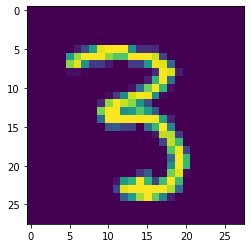

In [36]:
plt.imshow(X_train[2].reshape(28,28))
print(Y_train[2])

In [37]:
#Load submission X data
X_out = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
X_out = X_out.to_numpy().reshape(28000,28,28,1)
X_out = X_out/255

# Implementation Using TensorFlow 1.14

In [38]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """
    X = tf.placeholder("float32",[None,n_H0,n_W0,n_C0])
    Y = tf.placeholder("float32",[None,n_y])
    
    return X, Y

In [ ]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

In [ ]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 1, 8]
                        W2 : [2, 2, 8, 16]
    Normally, functions should take values as inputs rather than hard coding.
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.compat.v1.set_random_seed(1)                              
    
    W1 = tf.get_variable("W1",[4,4,1,8],initializer= tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer= tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [ ]:
#Check if the function works fine
tf.reset_default_graph()
with tf.compat.v1.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1[1,1,1] = \n" + str(parameters["W1"]))
    print("W1.shape: " + str(parameters["W1"].shape))
    print("\n")
    print("W2[1,1,1] = \n" + str(parameters["W2"]))
    print("W2.shape: " + str(parameters["W2"].shape))

In [ ]:
#Let us define forwaed_propagation for the CNN

def forward_propagation(X,parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    #Get the parameters from the dict
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    #CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
    
    #RELU Activation
    A1 = tf.nn.relu(Z1)
    
    # MAX POOL: window 8*8, stride 8, padding SAME
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=8,padding="SAME")
    
    #CONV2D : filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    
    #RELU Activation
    A2 = tf.nn.relu(Z2)
    
    #MAXPOOL: window 4*4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=4,padding="SAME")
    
    #FLATTEN
    F = tf.contrib.layers.flatten(P2)
    
    #Fully-connected
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 10 neurons in output layer.
    Z3 = tf.contrib.layers.fully_connected(F,10,activation_fn=None)
    
    
    return Z3   

In [ ]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 1, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,1), Y: np.random.randn(2,6)})
    print("Z3 = \n" + str(a))
    print(Z3)

In [ ]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 6)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    
    return cost

In [ ]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 1, 10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,1), Y: np.random.randn(4,10)})
    print("cost = " + str(a))

In [ ]:

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [ ]:
#Implemente a CNN model using TensorFlow having the following layers
# CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FC

def model(X_train,Y_train,X_test,Y_test,learning_rate = 0.009, num_epochs = 100,minibatch_size  = 64, print_cost = True):
    """
    Arguments:
    X_train -- training set, of shape (None, 28, 28, 1)
    Y_train -- test set, of shape (None, n_y = 10)
    X_test -- training set, of shape (None, 28, 28, 1)
    Y_test -- test set, of shape (None, n_y = 10)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    
    (m,n_H0,n_W0,n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []                                        # to keep track of costs
    
    #Create placeholders of correct shape
    X, Y = tf.placeholder("float32",[None,n_H0,n_W0,n_C0]),tf.placeholder("float32",[None,n_y])
    
    #Initialize the parameters
    parameters = initialize_parameters()
    
    #forward propagate
    Z3 = forward_propagation(X,parameters)
    
    #Compute the cost
    cost = compute_cost(Z3,Y)
    
    #Backpropagation: Use AdamOptimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                """
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost.
                # The feedict should contain a minibatch for (X,Y).
                """
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        
#         Z_test = forward_propagation(X_sub,parameters)
#         predict_op_test = tf.argmax(Z_test, 1)
#         test_sub_accuracy = accuracy.eval({X: X_test, Y: Y_test})   
        
        return train_accuracy, test_accuracy, parameters
    
    

In [ ]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

# Implementation Using Keras

In [ ]:
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)


In [ ]:
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

In [ ]:
def KerasModel(input_shape):
            
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset
        (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    

    Returns:
    model -- a Model() instance in Keras
    """
    
    
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    X = X_input
    
    X = Conv2D(8, (16, 16), strides = (1, 1),padding="SAME", name = 'conv00')(X)
    #Lets see the effect due to adding BN
    X = BatchNormalization(axis = 3, name = 'bn00')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D(pool_size=(32, 32),strides=(4,4),padding="SAME", name='max_pool01')(X)
   
    X = Conv2D(16, (8, 8), strides = (1, 1),padding="SAME", name = 'conv01')(X)
    #Lets see the effect due to adding BN
    X = BatchNormalization(axis = 3, name = 'bn01')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D(pool_size=(16, 16),strides=(8,8),padding="SAME", name='max_pool00')(X)
    
    #CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FC
    X = Conv2D(32, (4, 4), strides = (1, 1),padding="SAME", name = 'conv0')(X)
    #Lets see the effect due to adding BN
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D(pool_size=(8, 8),strides=(8,8),padding="SAME", name='max_pool0')(X)
    
    X = Conv2D(64, (2, 2), strides = (1, 1),padding="SAME", name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D(pool_size=(4, 4),strides=(4,4),padding="SAME", name='max_pool1')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(10, activation='softmax', name='fc',  kernel_initializer="glorot_uniform")(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='mnistModel')
    
    
    return model

In [ ]:
model = KerasModel(X_train.shape[1:])

In [ ]:
model.compile(optimizer="adam",loss='binary_crossentropy',metrics=["accuracy"])


In [ ]:
model.fit(X_train,Y_train,batch_size=64,epochs=70)

In [ ]:
#Compute the accuracy for the dev test
preds = model.evaluate(X_test,Y_test)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

In [ ]:
#Find the submission predictions
pred_out = model.predict(X_out)

In [ ]:
#Find the label corresponding to max prediction
pred_argmax = np.argmax(pred_out,1)
pred_argmax

In [ ]:
ImageId = list(range(1,len(pred_argmax)+1))
data_out = {'ImageId':ImageId, 'Label':pred_argmax} 

In [ ]:
out_df = pd.DataFrame(data_out)
out_df

In [ ]:
#Write to csv
out_df.to_csv('/kaggle/working/submission_4_64_100.csv',index=False)

### Yet Another CNN Model

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten

In [201]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

model = Sequential()
model.add(Convolution2D(32, (3, 3), padding="same", activation="relu",input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('sigmoid'))

In [202]:
# model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.compile(optimizer="adam",loss='binary_crossentropy',metrics=["accuracy"])

In [229]:
model.fit(X_train,Y_train,batch_size=64,epochs=10)

Epoch 1/10
33600/33600 [==============================] - 4s 108us/step - loss: 0.0033 - accuracy: 0.9990
Epoch 2/10
33600/33600 [==============================] - 3s 101us/step - loss: 0.0028 - accuracy: 0.9992
Epoch 3/10
33600/33600 [==============================] - 3s 94us/step - loss: 0.0033 - accuracy: 0.9990
Epoch 4/10
33600/33600 [==============================] - 3s 101us/step - loss: 0.0030 - accuracy: 0.9991
Epoch 5/10
33600/33600 [==============================] - 3s 90us/step - loss: 0.0028 - accuracy: 0.9991
Epoch 6/10
33600/33600 [==============================] - 3s 92us/step - loss: 0.0031 - accuracy: 0.9990
Epoch 7/10
33600/33600 [==============================] - 3s 100us/step - loss: 0.0029 - accuracy: 0.9991
Epoch 8/10
33600/33600 [==============================] - 3s 96us/step - loss: 0.0031 - accuracy: 0.9990
Epoch 9/10
33600/33600 [==============================] - 3s 89us/step - loss: 0.0030 - accuracy: 0.9990
Epoch 10/10
33600/33600 [==========================

In [230]:
#Compute the accuracy for the dev test
preds = model.evaluate(X_test,Y_test,batch_size=64)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

8400/8400 [==============================] - 0s 39us/step

Loss = 0.0058585868515011776
Test Accuracy = 0.9987378120422363


In [231]:
pred_out = model.predict_classes(X_out)
pred_out

array([2, 0, 9, ..., 3, 9, 2])

In [232]:
ImageId = list(range(1,len(pred_out)+1))
data_out = {'ImageId':ImageId, 'Label':pred_out} 
out_df = pd.DataFrame(data_out)
out_df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [233]:
#Write to csv
out_df.to_csv('/kaggle/working/submission_another_arch_7.csv',index=False)